In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from scipy.stats import t

In [2]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')
all_data = pd.concat([sample_a, sample_b])

In [3]:
all_data.head()

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


In [4]:
all_data['date'] = pd.to_datetime(all_data['date'], format='%Y-%m-%d')

In [5]:
all_data = all_data.groupby(['date', 'group']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'users_count'})

In [6]:
all_data.head()

,date,group,users_count,transactions,revenue
0,2020-11-06,A,2576,16,1577279
1,2020-11-06,B,2499,19,996645
2,2020-11-07,A,2704,23,1721886
3,2020-11-07,B,2804,19,555499
4,2020-11-08,A,3354,25,846051


In [7]:
all_data['cum_users_count'] = all_data.groupby(['group'])['users_count'].cumsum()
all_data['cum_transactions'] = all_data.groupby(['group'])['transactions'].cumsum()
all_data['cum_revenue'] = all_data.groupby(['group'])['revenue'].cumsum()
all_data['cum_conversion'] = all_data['cum_transactions']/all_data['cum_users_count']*100
all_data['cum_avg_check'] = all_data['cum_revenue']/all_data['cum_transactions']




In [8]:
all_data.groupby('group')['cum_conversion'].mean()

group
A    0.712755
B    0.762178
Name: cum_conversion, dtype: float64

In [9]:
all_data.head()

,date,group,users_count,transactions,revenue,cum_users_count,cum_transactions,cum_revenue,cum_conversion,cum_avg_check
0,2020-11-06,A,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-06,B,2499,19,996645,2499,19,996645,0.760304,52455.000000
2,2020-11-07,A,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
3,2020-11-07,B,2804,19,555499,5303,38,1552144,0.716576,40845.894737
4,2020-11-08,A,3354,25,846051,8634,64,4145216,0.741256,64769.000000


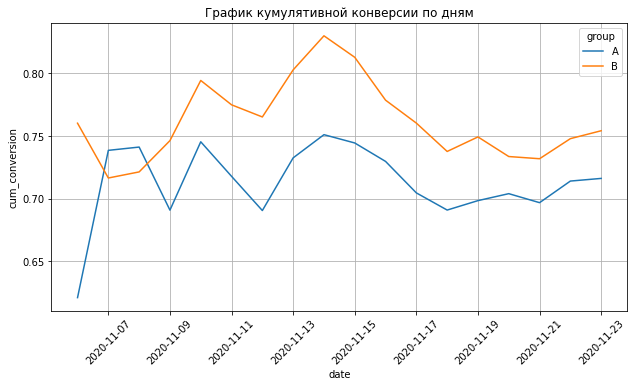

In [10]:
 #создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=all_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

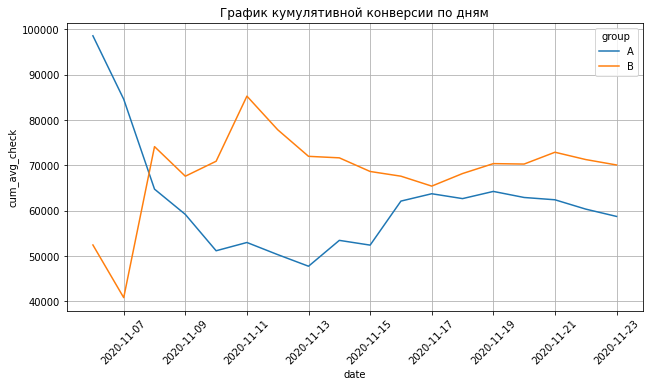

In [11]:
 #создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_avg_check', data=all_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

In [12]:
all_data.head()

,date,group,users_count,transactions,revenue,cum_users_count,cum_transactions,cum_revenue,cum_conversion,cum_avg_check
0,2020-11-06,A,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-06,B,2499,19,996645,2499,19,996645,0.760304,52455.000000
2,2020-11-07,A,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
3,2020-11-07,B,2804,19,555499,5303,38,1552144,0.716576,40845.894737
4,2020-11-08,A,3354,25,846051,8634,64,4145216,0.741256,64769.000000


### Задания из еда 5-5

In [13]:
ab_data = pd.concat([sample_a, sample_b])

In [14]:
ab_pivot =  ab_data.groupby(['group']).agg({
    'cid':'count',
    'transactions':'sum'
}).reset_index().rename(columns={'cid': 'count', 'transactions': 'sum'})
ab_pivot

,group,count,sum
0,A,61571,441
1,B,61383,463


In [15]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А меньше, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=ab_pivot['sum'], #число "успехов"
    nobs=ab_pivot['count'], #общее число наблюдений
    alternative='smaller',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


In [16]:
piv_data = ab_data.groupby(['date', 'group']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'users_count'})
piv_data

,date,group,users_count,transactions,revenue
0,2020-11-06,A,2576,16,1577279
1,2020-11-06,B,2499,19,996645
2,2020-11-07,A,2704,23,1721886
3,2020-11-07,B,2804,19,555499
4,2020-11-08,A,3354,25,846051
5,2020-11-08,B,3291,24,3044842
6,2020-11-09,A,3234,18,708830
7,2020-11-09,B,3062,25,1285836
8,2020-11-10,A,3022,29,826984
9,2020-11-10,B,3072,30,2414726


In [17]:
piv_data['avg_check'] = piv_data['revenue']/piv_data['transactions']

In [18]:
piv_data

,date,group,users_count,transactions,revenue,avg_check
0,2020-11-06,A,2576,16,1577279,98579.937500
1,2020-11-06,B,2499,19,996645,52455.000000
2,2020-11-07,A,2704,23,1721886,74864.608696
3,2020-11-07,B,2804,19,555499,29236.789474
4,2020-11-08,A,3354,25,846051,33842.040000
5,2020-11-08,B,3291,24,3044842,126868.416667
6,2020-11-09,A,3234,18,708830,39379.444444
7,2020-11-09,B,3062,25,1285836,51433.440000
8,2020-11-10,A,3022,29,826984,28516.689655
9,2020-11-10,B,3072,30,2414726,80490.866667


In [19]:
a_data =piv_data[piv_data['group'] == 'A']
b_data =piv_data[piv_data['group'] == 'B']


In [20]:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(a_data['avg_check'])
shapiro_result_b = shapiro(b_data['avg_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.01
p-value группы B 0.02
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [21]:
ab_data

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A
...,...,...,...,...,...
61378,2020-11-23,9.965675e+08,0,0,B
61379,2020-11-23,9.970803e+07,0,0,B
61380,2020-11-23,9.984814e+08,0,0,B
61381,2020-11-23,9.991118e+08,0,0,B


In [22]:
H0 = 'Ежедневные средние чеки в группах А и В равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.1 # уровень значимости
_, p = mannwhitneyu(a_data['avg_check'], b_data['avg_check'], alternative='less')

p = round(p, 1)

if p>alpha:
   print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}")
else:
  print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу. {H1}")

0.1 <= 0.1. Мы отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше, чем в группе B


# Доверительный Интервал для пропорции

In [23]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()


,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [24]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

# Функция доверительный интервал для пропорции с Z критическим

In [25]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [26]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


# доверительный интервал разницы пропорций (конверсий).

In [27]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [28]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 
# Доверительный интервал для разности конверсий: (-0.39, 0.08)

Доверительный интервал для разности конверсий: (-0.39, 0.08)


In [34]:
proportions_conf_interval(189, 0.698, gamma = 0.9)

(64.31, 75.29)

In [35]:
def conversion_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)
n = 189 # размер выборки
n_positive = 132 # число положительных исходов
x_p = n_positive/n # выборочная пропорция
print('Выборочная пропорция: {}'.format(round(x_p, 3)))
 
print('Доверительный интервал: {}'.format(conversion_conf_interval(n, x_p, gamma=0.9)))

Выборочная пропорция: 0.698
Доверительный интервал: (64.35, 75.33)


In [38]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)
 
n = 1000 # размер выборки обеих групп
n_positive_a = 45 # число конвертировавших в группе А
n_positive_b = 50 # число конвертировавших в группе B
xp_a = n_positive_a/n # выборочная пропорция группы A
xp_b = n_positive_b/n # выборочня пропорция группы B
confidence_interval = diff_proportions_conf_interval(
    n=[n, n],
    xp=[xp_a, xp_b]
)
print('Доверительный интервал: {}'.format(confidence_interval))

Доверительный интервал: (-1.36, 2.36)
